In [1]:
!https_proxy=http://192.41.170.23:3128 http_proxy=http://192.41.170.23:3128 pip install mne

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io
import mne
import pooch
from mne import create_info
from mne.io import RawArray
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
import glob
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [3]:
# choose file .edf from 10 subjects which endwith 03,07,11,04,08,12 .edf which are taks3 and task4
edf_file = glob.glob("Project/datasets1/MNE-eegbci-data/files/eegmmidb/1.0.0/*/*.edf") #10

edf_files = []
print(len(edf_files))   
for file_name in edf_file:
    if file_name.endswith('03.edf') or file_name.endswith('07.edf') \
        or file_name.endswith('11.edf') \
        or file_name.endswith('04.edf') \
        or file_name.endswith('08.edf')\
        or file_name.endswith('12.edf'):
        
        edf_files.append(file_name)
print(len(edf_files))   

0
60


In [4]:
# concat all the file and read raw data
raws = [read_raw_edf(f, preload=True) for f in edf_files]
raw_obj = concatenate_raws(raws)
raw_obj

Extracting EDF parameters from /home/st122497/work/Project/Project/datasets1/MNE-eegbci-data/files/eegmmidb/1.0.0/S009/S009R07.edf...
EDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., Cz.., C2.., C4.., C6.., Cp5., Cp3., Cp1., Cpz., Cp2., Cp4., Cp6., Fp1., Fpz., Fp2., Af7., Af3., Afz., Af4., Af8., F7.., F5.., F3.., F1.., Fz.., F2.., F4.., F6.., F8.., Ft7., Ft8., T7.., T8.., T9.., T10., Tp7., Tp8., P7.., P5.., P3.., P1.., Pz.., P2.., P4.., P6.., P8.., Po7., Po3., Poz., Po4., Po8., O1.., Oz.., O2.., Iz..
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/st122497/work/Project/Project/datasets1/MNE-eegbci-data/files/eegmmidb/1.0.0/S009/S009R03.edf...
EDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be 

<RawEDF | S009R07.edf, 64 x 1186560 (7416.0 s), ~579.4 MB, data loaded>

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 sec)

Effective window size : 12.800 (s)


/tmp/ipykernel_938/2411324713.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_obj.plot_psd()


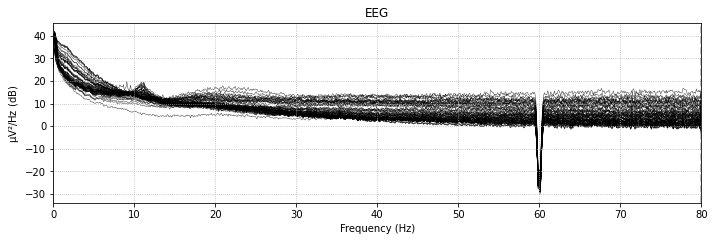

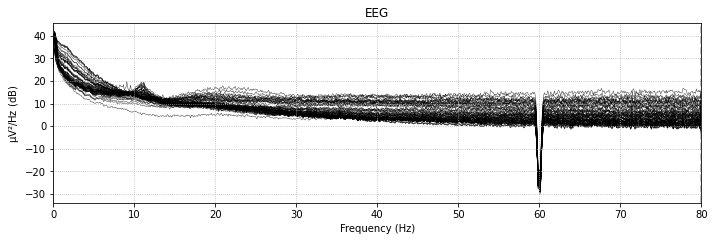

In [5]:
#notch filter removed 60 Hz 
raw_obj=raw_obj.notch_filter(60, filter_length='auto', phase='zero') 
raw_obj.plot_psd()

Filtering raw data in 60 contiguous segments
Setting up band-pass filter from 0.5 - 70 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 70.00 Hz: -6.02, -6.02 dB

Effective window size : 12.800 (s)


/tmp/ipykernel_938/2935876648.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_obj.plot_psd()


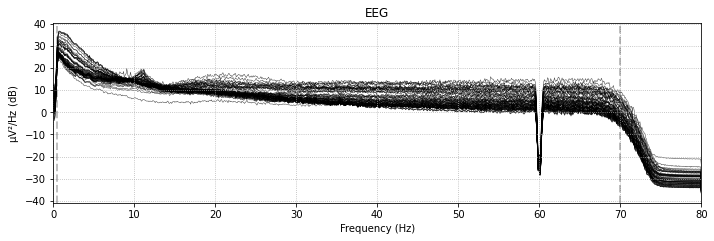

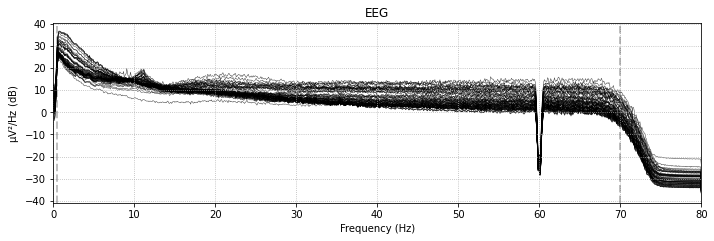

In [6]:
#  a band-pass filter was applied to allow a frequency range of 0.5 ´ 70 Hz
raw_obj = raw_obj.filter(0.5, 70, method='iir')
raw_obj.plot_psd()

In [7]:
event_id = dict(T1=0, T2=1) # the events we want to extract
events, event_ids = mne.events_from_annotations(raw_obj, event_id=event_id)
# events, event_ids = mne.events_from_annotations(raw_obj)
event_ids

Used Annotations descriptions: ['T1', 'T2']


{'T1': 0, 'T2': 1}

In [8]:
# map event and select channel
tmin, tmax = 0, 4 
epochs = mne.Epochs(raw_obj, events, event_ids, tmin, tmax, baseline=None ,preload=True)

Not setting metadata
Not setting metadata
900 matching events found
No baseline correction applied
0 projection items activated
Loading data for 900 events and 641 original time points ...
0 bad epochs dropped


In [9]:
data = epochs._data
data.shape

(900, 64, 641)

In [10]:
epoch_t1 = epochs['T1'].average()
epoch_t2 = epochs['T2'].average()

/tmp/ipykernel_938/637377437.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epoch_t1.plot(spatial_colors=True, time_unit='s');


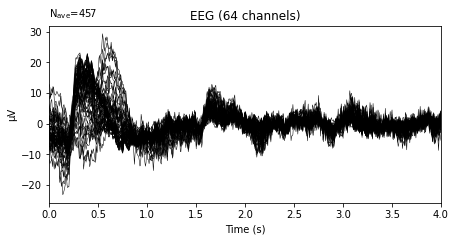

/tmp/ipykernel_938/637377437.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epoch_t2.plot(spatial_colors=True, time_unit='s');


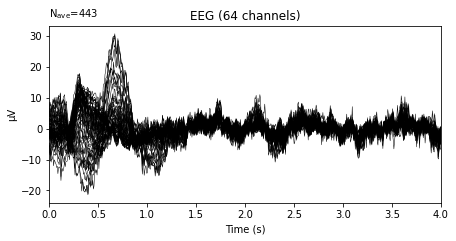

In [11]:
# visualize data
epoch_t1.plot(spatial_colors=True, time_unit='s');
epoch_t2.plot(spatial_colors=True, time_unit='s');

combining channels using "gfp"
combining channels using "gfp"


/tmp/ipykernel_938/3856120567.py:1: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds(dict(t1=epoch_t1, t2=epoch_t2),


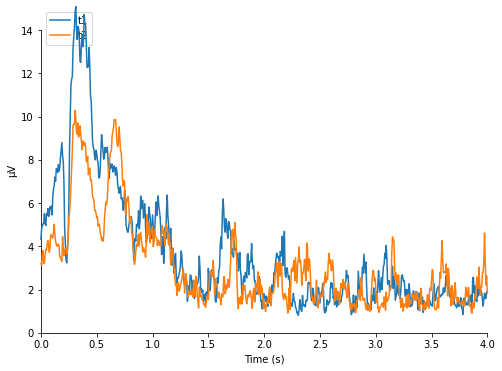

[<Figure size 576x432 with 1 Axes>]

In [12]:
# visualize data
mne.viz.plot_compare_evokeds(dict(t1=epoch_t1, t2=epoch_t2),
                             legend='upper left', show_sensors='upper right')

    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_938/1325064077.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs['T1'].plot_psd();


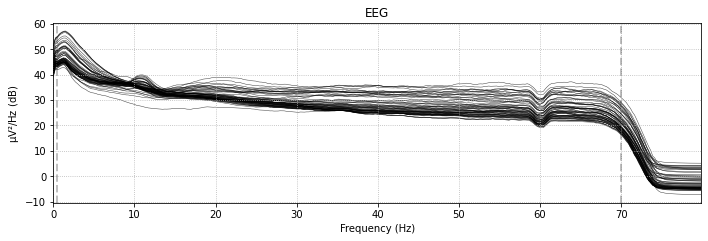

    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_938/1325064077.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs['T2'].plot_psd();


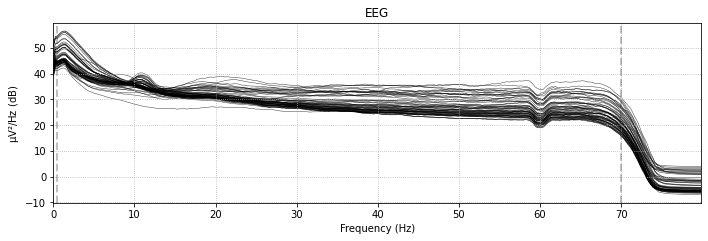

In [13]:
# visualize data
epochs['T1'].plot_psd();
epochs['T2'].plot_psd();


In [14]:
# define X and Y
y = epochs.events[:, -1]
torch_X = torch.from_numpy(data)
torch_y = torch.from_numpy(y)
torch_X_reshaped = torch_X.permute(0, 2, 1)
print("Converted X: ", torch_X_reshaped.size(),"y",torch_y.shape)


Converted X:  torch.Size([900, 641, 64]) y torch.Size([900])


In [15]:
print(set(y))

{0, 1}


In [16]:
# split data 
X_train, X_test, y_train, y_test = train_test_split(torch_X_reshaped,torch_y, test_size=0.3)
print(X_train.shape, y_train.shape)

torch.Size([630, 641, 64]) torch.Size([630])


In [17]:
torch.unique(torch_y)

tensor([0, 1])

In [18]:
# import data to data loader
batch_size = 50
def create_dataloader(X, y, batch_size):
    X_tensor = torch.tensor(X).float()
    y_tensor = torch.tensor(y).long()
    dataset_tensor = TensorDataset(X_tensor, y_tensor)
    dl = torch.utils.data.DataLoader(dataset_tensor, batch_size=batch_size, shuffle=True)
    return dl
train_loader = create_dataloader(X_train, y_train, batch_size=batch_size)
test_loader = create_dataloader(X_test, y_test, batch_size=batch_size)

/tmp/ipykernel_938/1029740696.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X).float()
/tmp/ipykernel_938/1029740696.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).long()


In [19]:
len(train_loader)

13

In [21]:
for i, (signal, label) in enumerate(train_loader):
    print(i, (signal.shape, label.shape))
    break

0 (torch.Size([50, 641, 64]), torch.Size([50]))


In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
print(device)


cpu


In [33]:
input_dim = 64
hidden_dim = 128
num_layers = 3
num_classes = 1
output_dim = 1
bidirectional = True
dropout0 = 0.0
dropout1 = 0.2
dropout2 = 0.1
dropout3 = 0.2
# embed_dim = 64
num_epochs = 30
num_layers = 1
batch_size=32
# create model LSTM Bi direction with attention 
import torch.nn as nn
from torch.nn import functional as F
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, 
                           hidden_dim, 
                           num_layers=num_layers, 
                           bidirectional=bidirectional, 
                           dropout=0.2,
                           batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout1 = nn.Dropout(dropout1)
        self.dropout2 = nn.Dropout(dropout2)
        self.dropout3 = nn.Dropout(dropout3)
    
    def attention_net(self, lstm_output, final_state):
        hidden = final_state.unsqueeze(2)  # hidden : [batch_size, n_hidden * num_directions(=2), 1(=n_layer)]
        attn_weights = torch.bmm(lstm_output, hidden).squeeze(2) # attn_weights : [batch_size, seq_len, 1]
        soft_attn_weights = F.softmax(attn_weights, 1)
        context = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
        return context, soft_attn_weights.cpu().data.numpy() # context : [batch_size, n_hidden * num_directions(=2)]

    def forward(self, text,batch_size):
        
        output, (hn, cn) = self.lstm(text)  #if no h0, all zeroes
        output = self.dropout1(output)
        output = self.dropout2(output)
        output = self.dropout3(output)
        hn = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim = 1)
        
        attn_output, attention = self.attention_net(output, hn)
        return self.fc(attn_output), attention

In [34]:
model = LSTM().float()

In [35]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model {type(model).__name__} has {count_parameters(model):,} trainable parameters')# Train the model

The model LSTM has 198,913 trainable parameters


In [36]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param) #<---here


In [37]:
w = torch.empty(3, 5)
nn.init.orthogonal_(w)
model.apply(initialize_weights)

LSTM(
  (lstm): LSTM(64, 128, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
  (dropout3): Dropout(p=0.2, inplace=False)
)

In [38]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(),betas = (0.9,0.999),weight_decay= 0.01, lr=0.001)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.CrossEntropyLoss()

In [39]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [40]:
import sys
def train(loader):
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    for i, (signal, labels) in enumerate(loader):
        signal = signal.to(device)
        labels = labels.to(device)
        # print(signal)
                
        #predict
        outputs, attention = model(signal,batch_size=batchsize)
        print(outputs.shape)
        # outputs = outputs.float()
        # labels = labels.reshape(-1,1)
        outputs = outputs.squeeze(1)
        labels = labels.float()
        print('down',outputs)
        
        
        #calculate loss
        loss = criterion(outputs, labels)
        acc = binary_accuracy(outputs, labels)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        if (i+1) % 1 == 0:
            sys.stdout.write ('\rEpoch [{}/{}], Step [{}/{}], Loss: {:.4f}, acc {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, len(loader), loss.item(),acc))
                
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [41]:
def evaluate(loader):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (signal, labels) in enumerate(loader): 
            labels = labels.to(device) #(batch_size, )
            signal = signal.to(device) #(batch_size, seq len)
            
            outputs, attention = model(signal,batch_size=batchsize)
            outputs = outputs.squeeze(1)
            labels = labels.float()
            # outputs = outputs.float()
            
            loss = criterion(outputs, labels)        
            acc = binary_accuracy(outputs, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            if (i+1) % 1 == 0:
                sys.stdout.write ('\rEpoch [{}/{}], Step [{}/{}], Loss: {:.4f}, acc {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, len(loader), loss.item(),acc))
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [42]:
best_valid_loss = float('inf')

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
batchsize =50
for epoch in range(num_epochs):
    
    train_loss, train_acc = train(train_loader)
    valid_loss, valid_acc = evaluate(test_loader)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        
    
    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

torch.Size([50, 1])
down tensor([ 5.5610e-07,  3.4513e-07,  3.3720e-08,  2.1897e-07, -3.0709e-07,
         1.0865e-06, -3.0785e-07,  5.8209e-07, -1.0236e-07,  6.4134e-08,
         5.7815e-09,  7.6890e-07,  5.0260e-08,  9.9454e-07, -4.1602e-07,
         1.5392e-07,  4.5101e-07,  3.7384e-08,  5.9947e-07, -1.5400e-07,
        -1.6691e-08,  2.4602e-07,  9.3956e-07,  1.8831e-07, -1.4813e-07,
         1.4902e-07,  2.2173e-07,  3.4389e-08,  1.3211e-06,  2.3461e-07,
         1.9533e-07,  1.1443e-07,  1.4213e-06,  1.7125e-07,  1.8163e-08,
         1.5846e-07,  2.5248e-07, -2.8212e-07,  1.1850e-06, -7.1664e-07,
        -2.2732e-07, -1.9711e-07, -3.8930e-07, -2.7031e-07,  3.9931e-08,
        -2.7901e-07,  2.1195e-07,  4.8985e-07,  7.1253e-08, -1.0049e-06],
       grad_fn=<SqueezeBackward1>)
Epoch [1/30], Step [1/13], Loss: 0.6931, acc 0.5400torch.Size([50, 1])
down tensor([-0.0181, -0.0182, -0.0182, -0.0182, -0.0182, -0.0181, -0.0181, -0.0182,
        -0.0181, -0.0181, -0.0182, -0.0182, -0.0181, 

Text(0.5, 1.0, 'BI-LSTM 64 electrodes, 10 subjects')

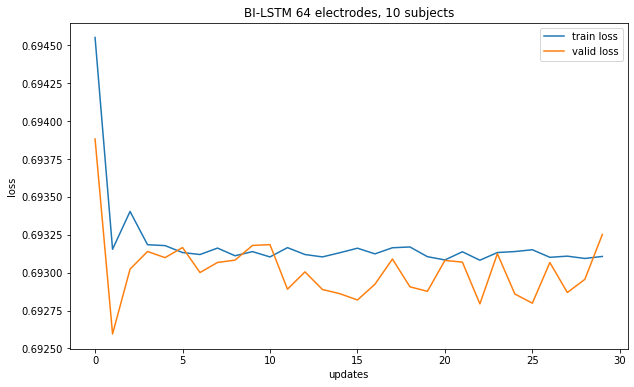

In [46]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')
plt.title("BI-LSTM 64 electrodes, 10 subjects")

Text(0.5, 1.0, 'BI-LSTM 64 electrodes, 10 subjects')

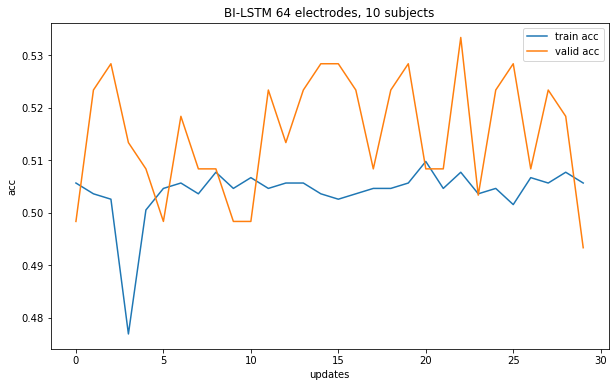

In [45]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')
plt.title("BI-LSTM 64 electrodes, 10 subjects")